In [2]:
import sys
sys.path.append('~/transinet4lsst')
from lsst.daf.butler import Butler
import pandas as pd
from mask_tools import should_ignore, get_enabled_flags_names
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

#### First obtain the truth list, the way we do as of now:

In [4]:
collection = sys.argv[1] if len(sys.argv)>1 else 'latest' #pick the latest collection in the butler registry by default

# Create a lsst butler object
butler = Butler('/repo/apv')

# The dimensions of the specific image we want to look at
visit = 982985
detector = 164


#--- Get the truth file URI (which is right next to the calexp file)
sciFile = butler.getURI('calexp',
                        collections='ap_verify-output',
                        dataId={'instrument': 'LSSTCam-imSim', 'visit': visit, 'detector': detector}).ospath
truthfile = sciFile + '.SNVAR.parq'
print(truthfile)



#--- Obtain mask info for truth rows
truth = pd.read_parquet(truthfile, engine='pyarrow')
sci = butler.get('calexp',
                 collections='ap_verify-output',
                 dataId={'instrument': 'LSSTCam-imSim', 'visit': visit, 'detector': detector})

X,Y = sci.getWcs().skyToPixelArray(ra=truth['ra'],dec=truth['dec'],degrees=True)
truth = truth.assign(x=X,y=Y) # add x,y columns to truth
mask = sci.getMaskedImage().getMask()
truth['mask'] = mask.getArray()[truth['y'].astype(int),truth['x'].astype(int)]
truth = truth[~truth.apply(lambda row: should_ignore(row['mask']), axis=1)]

truth

/repo/apv/ap_verify-output/20230307T235531Z/calexp/20251218/r/r_sim_1.4/982985/calexp_LSSTCam-imSim_r_r_sim_1_4_982985_R41_S02_ap_verify-output_20230307T235531Z.fits.SNVAR.parq


,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,is_good_match,is_nearest_neighbor,is_unique_truth_entry,obsHistID,MJD,bandpass,delta_flux,x,y,mask
0,MS_9300_3652,4126946327,55.809744,-32.332801,0.945324,1,1,0.000000,0.000000,0.000000,...,False,False,True,982985,61028.122882,r,7.922391,1836.168943,1786.292517,32
1,MS_9300_4184,4127142911,55.933019,-32.284723,0.973225,1,1,0.000000,0.000000,0.000000,...,False,False,True,982985,61028.122882,r,17.903126,3608.015876,721.816330,32
0,31411429981,-1,55.820381,-32.364658,0.000000,1,1,2.310072,20.113888,56.057739,...,False,False,True,982985,61028.122882,r,-0.417352,2059.019139,2339.377328,0
1,31107745011,-1,55.815901,-32.372821,0.000000,1,1,3636.093994,30671.835938,93393.062500,...,True,True,True,982985,61028.122882,r,-529.692749,2007.168215,2493.043168,32
2,31411429992,-1,55.808551,-32.365349,0.000000,1,1,13.605010,106.517334,291.346863,...,True,True,True,982985,61028.122882,r,17.688076,1881.492080,2371.355936,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,31411420425,-1,55.818703,-32.271713,0.000000,1,1,78.645859,625.545532,1591.176880,...,True,True,True,982985,61028.122882,r,166.295044,1852.781897,677.221716,32
69,31411420361,-1,55.823281,-32.270895,0.000000,1,1,157.305634,733.933716,1367.034668,...,True,True,True,982985,61028.122882,r,6.967145,1920.474664,654.990029,32
70,31411421139,-1,55.816579,-32.278785,0.000000,1,1,71.119019,360.440216,721.109192,...,True,True,True,982985,61028.122882,r,-0.209456,1834.409383,807.407486,32
71,31500328834,-1,55.745089,-32.239291,0.000000,1,1,7.432840,61.144257,180.943069,...,True,True,True,982985,61028.122882,r,-0.008144,675.142659,218.946644,0


#### Now Bruno's version

In [6]:
# Download the truth catalog
Brunos = pd.read_csv('https://jira.lsstcorp.org/secure/attachment/70798/varstar_truth_cat_DC2_visit_982985_det_164.csv')

Brunos

,id,ra,dec,flux_u,flux_g,flux_r,flux_i,flux_z,flux_y,is_pointsource,...,delta_flux,bandpass,obshistid,visit,detector,x_image,y_image,in_ccd,flux,transient_type
0,31411429981,55.820381,-32.364658,2.31007,20.1139,56.0577,87.3304,106.848,119.715,1,...,-0.417352,r,982985,982985,164,2067.755518,2330.004105,True,55.640348,VariableStar
1,31107745011,55.815901,-32.372821,3636.09000,30671.8000,93393.1000,156149.0000,199435.000,227464.000,1,...,-529.692743,r,982985,982985,164,2016.305992,2483.649238,True,92863.407257,VariableStar
2,31411429992,55.808551,-32.365349,13.60500,106.5170,291.3470,453.5000,555.443,620.171,1,...,17.688076,r,982985,982985,164,1890.330502,2362.300951,True,309.035076,VariableStar
3,31405687653,55.769400,-32.385121,321.08500,1358.9700,2467.4500,3095.5700,3397.010,3610.070,1,...,1.449948,r,982985,982985,164,1338.102880,2782.289372,True,2468.899948,VariableStar
4,31411430598,55.784715,-32.371861,15260.90000,35802.8000,48942.8000,54859.8000,56619.300,57118.900,1,...,-72.041725,r,982985,982985,164,1543.054872,2519.074789,True,48870.758275,VariableStar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,31411420425,55.818703,-32.271713,78.64590,625.5460,1591.1800,2349.9100,2796.330,3095.530,1,...,166.295041,r,982985,982985,164,1857.348685,669.379301,True,1757.475041,VariableStar
73,31411420361,55.823281,-32.270895,157.30600,733.9340,1367.0300,1729.1700,1901.450,2026.320,1,...,6.967145,r,982985,982985,164,1924.983370,647.026668,True,1373.997145,VariableStar
74,31411421139,55.816579,-32.278785,71.11900,360.4400,721.1090,950.9970,1068.600,1147.030,1,...,-0.209456,r,982985,982985,164,1839.299007,799.524819,True,720.899544,VariableStar
75,31500328834,55.745089,-32.239291,7.43284,61.1443,180.9430,296.0500,372.691,421.181,1,...,-0.008144,r,982985,982985,164,678.663710,213.671488,True,180.934856,VariableStar


#### Comparison plots (what we already have under DM-40191)

<IPython.core.display.Javascript object>


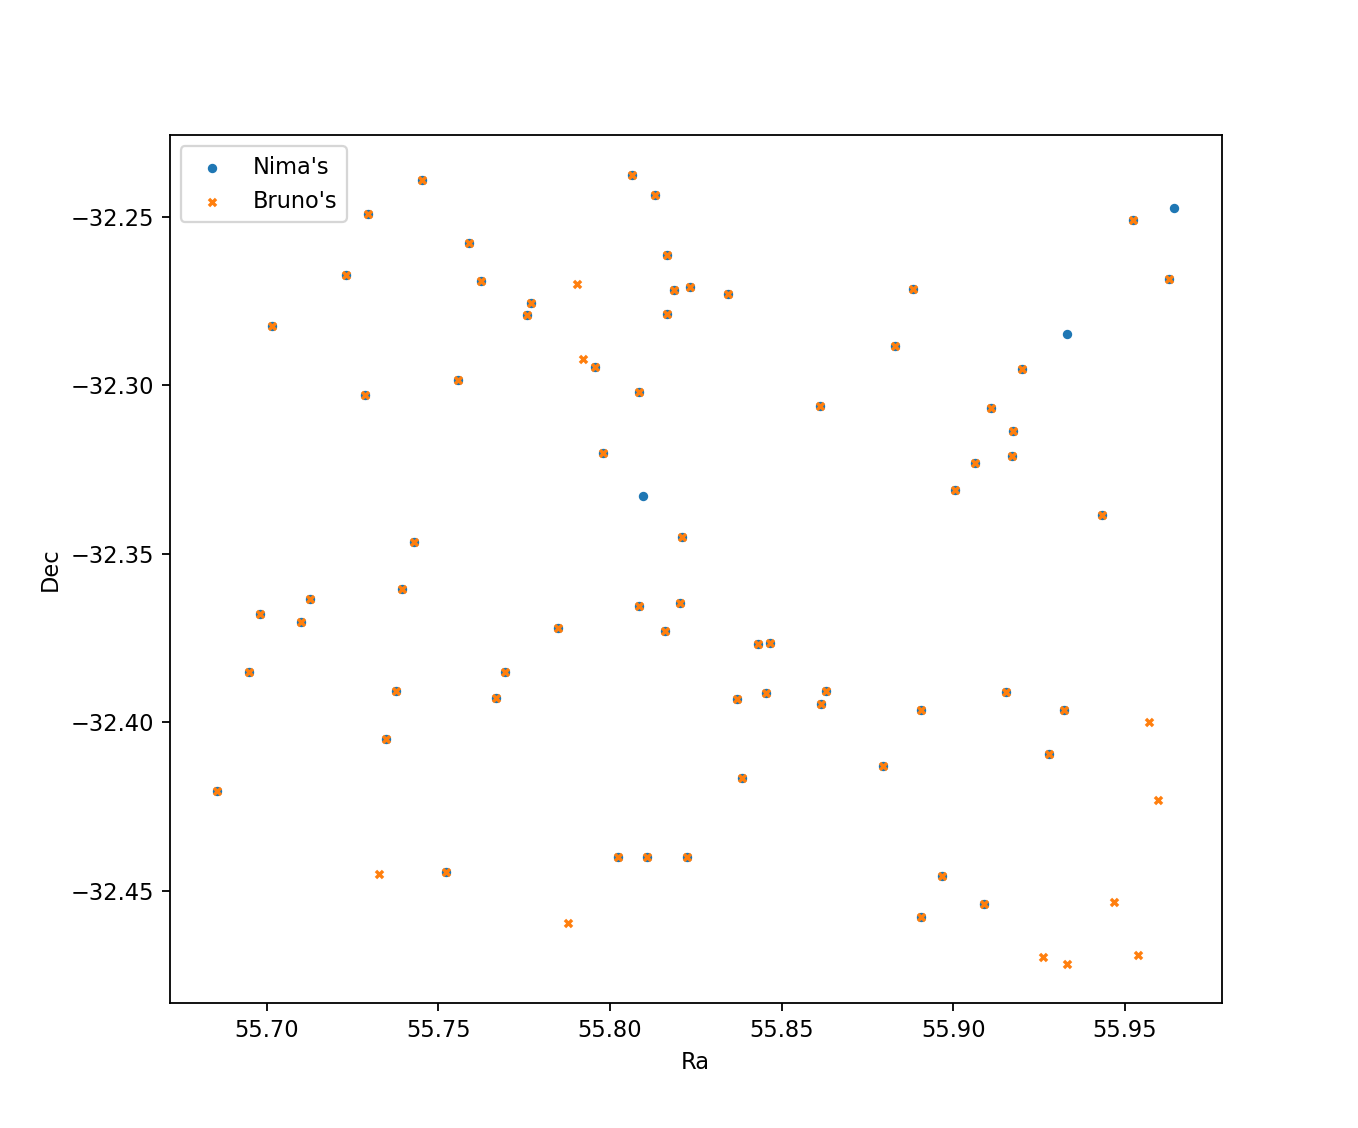

In [11]:
plt.figure()
plt.scatter(truth['ra'],truth['dec'],marker='o',s=10, label='Nima\'s')
plt.scatter(Brunos['ra'],Brunos['dec'],marker='x',s=10, label='Bruno\'s')
plt.xlabel('Ra')
plt.ylabel('Dec')
plt.legend()

#### Let's test the hypothesis that the bounding box is being interpreted differently

<IPython.core.display.Javascript object>


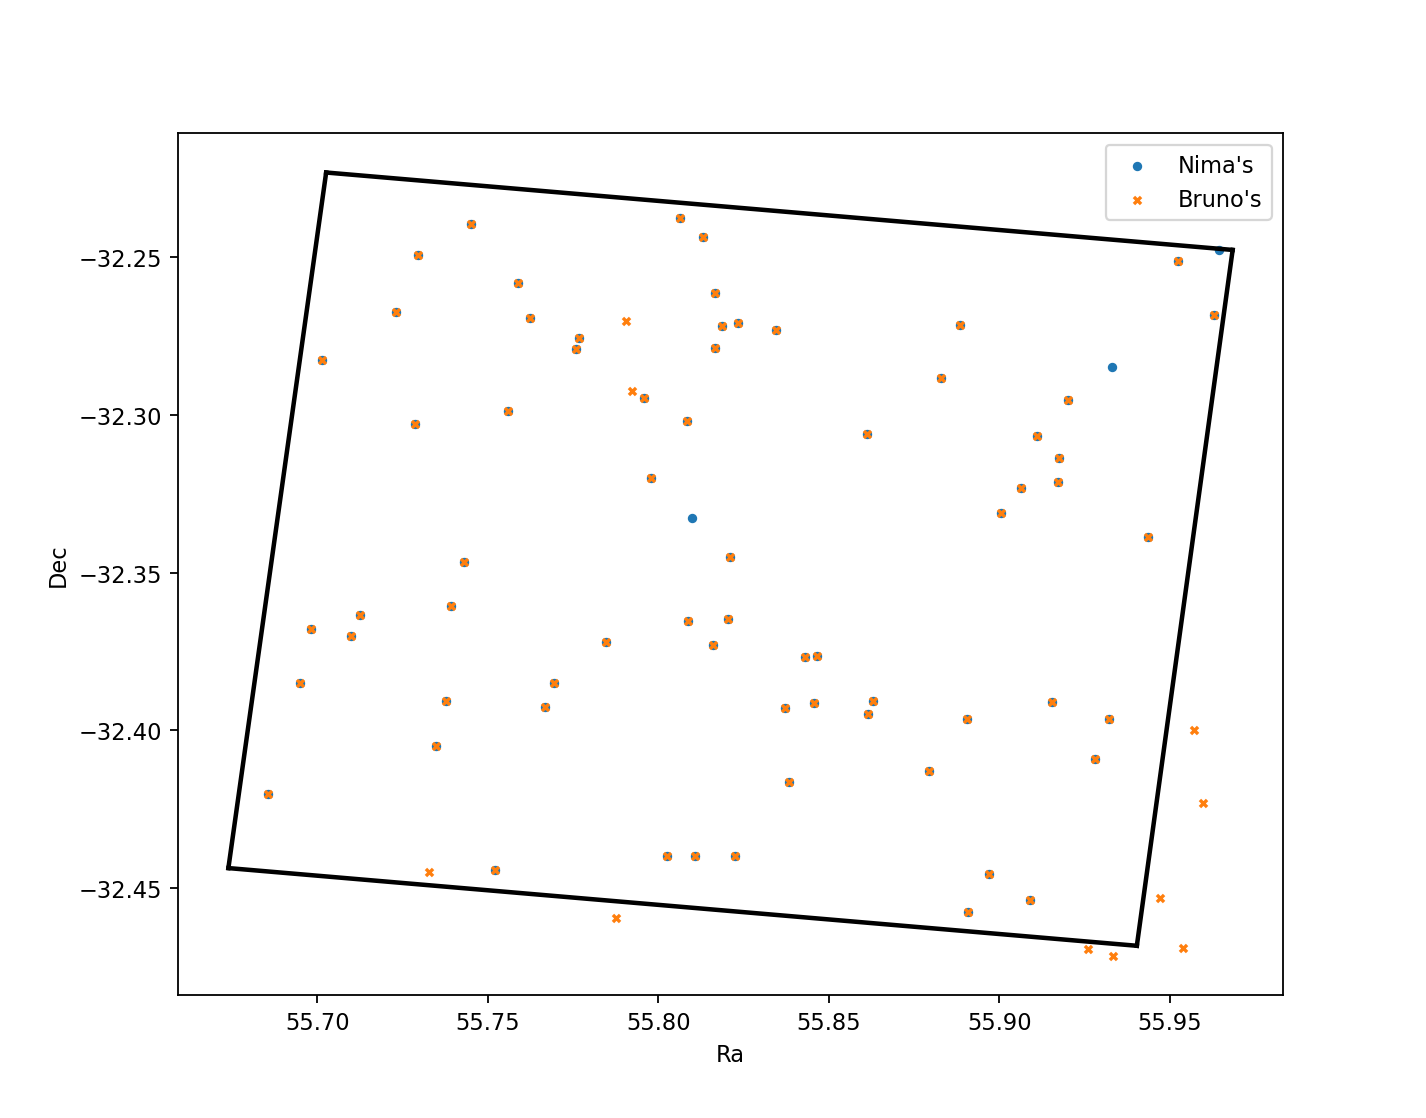

In [12]:
plt.figure()
plt.scatter(truth['ra'],truth['dec'],marker='o',s=10, label='Nima\'s')
plt.scatter(Brunos['ra'],Brunos['dec'],marker='x',s=10, label='Bruno\'s')
plt.xlabel('Ra')
plt.ylabel('Dec')
plt.legend()

# over-plot the calexp's bounding box.
sci = butler.get('calexp',
                 collections='ap_verify-output',
                 dataId={'instrument': 'LSSTCam-imSim', 'visit': visit, 'detector': detector})

# Convert the corners of the bounding boxes to sky coordinates.
from lsst.geom import SpherePoint, degrees, Box2D, Extent2D
from lsst import sphgeom
BBox = sci.getBBox()
wcs = sci.getWcs()
LocalBBox = Box2D(BBox)
BoxCorners = LocalBBox.getCorners()
SphCorners = [wcs.pixelToSky(corner).getVector() for corner in BoxCorners]
SkyRegion = sphgeom.ConvexPolygon(SphCorners)

## plot the sky region by connecting the corners
for i in range(4):
    plt.plot([SpherePoint(SphCorners[i]).getRa().asDegrees(), SpherePoint(SphCorners[(i+1)%4]).getRa().asDegrees()],
             [SpherePoint(SphCorners[i]).getDec().asDegrees(), SpherePoint(SphCorners[(i+1)%4]).getDec().asDegrees()],
                color='black',
                linewidth=2,
             )
